Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0308 - val_loss: 0.1240
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0137 - val_loss: 0.1055
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0089 - val_loss: 0.0999
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0103 - val_loss: 0.1066
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0084 - val_loss: 0.1147
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0108 - val_loss: 0.1152
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0115 - val_loss: 0.1144
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0129 - val_loss: 0.1111
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0111 - val_loss: 0.1077
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0097 - val_loss: 0.1059
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0114 - val_loss: 0.1070
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0085 - val_loss: 0.1103
Epoch 13/50

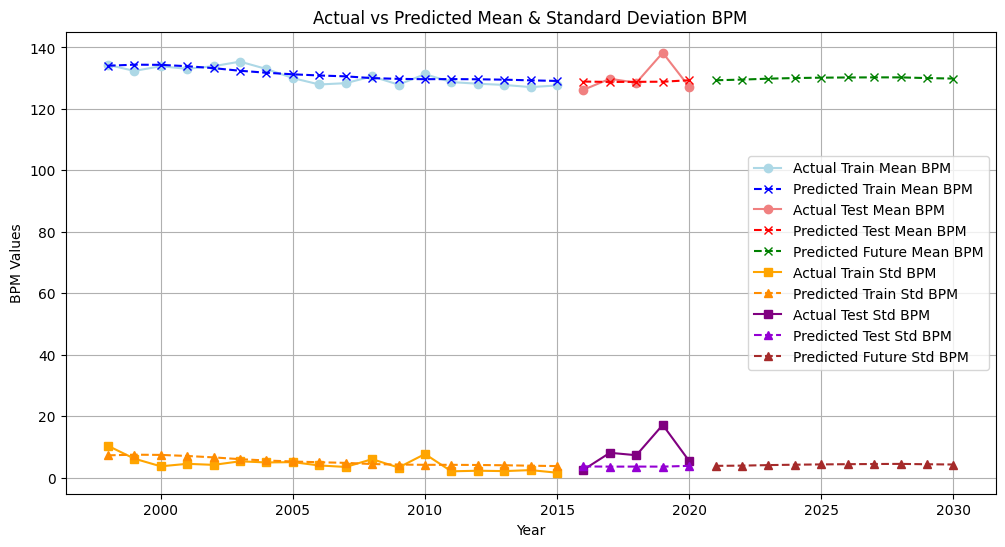

In [157]:
##### import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Load BPM dataset
bpm_data = pd.read_csv("mayday-bpm-analysis.csv")

# Select relevant columns and filter by year range
bpm_data = bpm_data[(bpm_data['Year'] >= 1992) & (bpm_data['Year'] <= 2020)]
features = ['Mean BPM', 'Standard Deviation BPM']

# Normalize data
scaler = MinMaxScaler()
bpm_data[features] = scaler.fit_transform(bpm_data[features])

# Prepare data for LSTM
sequence_length = 10  # Using past 10 years for prediction
X, y = [], []
for i in range(len(bpm_data) - sequence_length):
    X.append(bpm_data[features].iloc[i:i+sequence_length].values)
    y.append(bpm_data[features].iloc[i+sequence_length].values)
X, y = np.array(X), np.array(y)

# Split data into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, len(features))), Dropout(0.4),
    LSTM(50, return_sequences=False), Dropout(0.4), Dense(25), Dense(len(features))])

# Compile the model

model.compile(optimizer='adam', loss='mse')

from tensorflow.keras.callbacks import EarlyStopping

# 创建早期停止回调对象，监控 'val_loss'（验证集损失），并设定耐心为 10
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 训练模型，并在训练过程中应用早期停止
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)  # 降低学习率
model.compile(optimizer=optimizer, loss='mse')

# Predict on training and testing data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Convert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)

# Predict future BPM for the next 10 years
future_predictions = []
future_inputs = X[-1].reshape(1, sequence_length, len(features))
for _ in range(10):
    future_prediction = model.predict(future_inputs)[0]
    future_predictions.append(future_prediction)
    new_input = np.append(future_inputs[:, 1:, :], [[future_prediction]], axis=1)
    future_inputs = new_input

# Convert future predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)
future_mean_bpm = future_predictions[:, 0]
future_std_bpm = future_predictions[:, 1]

# Print future predictions
future_years = list(range(2021, 2031))
for year, mean_pred, std_pred in zip(future_years, future_mean_bpm, future_std_bpm):
    print(f"Predicted Mean BPM for {year}: {mean_pred}")
    print(f"Predicted Standard Deviation BPM for {year}: {std_pred}")

# Plot actual vs predicted BPM
plt.figure(figsize=(12, 6))
plt.plot(bpm_data['Year'][sequence_length:split+sequence_length], y_train_orig[:, 0], label="Actual Train Mean BPM", marker='o', color='lightblue')
plt.plot(bpm_data['Year'][sequence_length:split+sequence_length], train_predict[:, 0], label="Predicted Train Mean BPM", marker='x', linestyle='dashed', color='blue')
plt.plot(bpm_data['Year'][split+sequence_length:], y_test_orig[:, 0], label="Actual Test Mean BPM", marker='o', color='lightcoral')
plt.plot(bpm_data['Year'][split+sequence_length:], test_predict[:, 0], label="Predicted Test Mean BPM", marker='x', linestyle='dashed', color='red')
plt.plot(future_years, future_mean_bpm, label="Predicted Future Mean BPM", marker='x', linestyle='dashed', color='green')

# **新增：绘制 Standard Deviation BPM 的对比**

plt.plot(bpm_data['Year'][sequence_length:split+sequence_length], y_train_orig[:, 1], label="Actual Train Std BPM", marker='s', color='orange')
plt.plot(bpm_data['Year'][sequence_length:split+sequence_length], train_predict[:, 1], label="Predicted Train Std BPM", marker='^', linestyle='dashed', color='darkorange')
plt.plot(bpm_data['Year'][split+sequence_length:], y_test_orig[:, 1], label="Actual Test Std BPM", marker='s', color='purple')
plt.plot(bpm_data['Year'][split+sequence_length:], test_predict[:, 1], label="Predicted Test Std BPM", marker='^', linestyle='dashed', color='darkviolet')
plt.plot(future_years, future_std_bpm, label="Predicted Future Std BPM", marker='^', linestyle='dashed', color='brown')

# 轴标签 & 标题
plt.xlabel("Year")
plt.ylabel("BPM Values")
plt.title("Actual vs Predicted Mean & Standard Deviation BPM")
plt.legend()
plt.grid()
plt.show() 

In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 计算误差
train_mse = mean_squared_error(y_train_orig, train_predict)
test_mse = mean_squared_error(y_test_orig, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train_orig, train_predict)
test_mae = mean_absolute_error(y_test_orig, test_predict)

# 输出误差指标
print(f"Train MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")


Train MSE: 3.4929, RMSE: 1.8689, MAE: 1.6461
Test MSE: 32.4005, RMSE: 5.6921, MAE: 4.0007


In [159]:
from sklearn.metrics import mean_absolute_error
train_mae = mean_absolute_error(y_train_orig, train_predict)
test_mae = mean_absolute_error(y_test_orig, test_predict)
print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")

Train MAE: 1.6461354339525354, Test MAE: 4.000672543118687
